# Filtro de partículas


Cada partícula vai ser representada por uma lista [x,y,theta]

Trabalhe com 2 listas:

	S = []  # Vai conter as n partículas. 

	W = [] # Pesos das partículas

	n_part = # Número de partículas


# Atividades


1. Crie uma função que gere n partículas aleatórias distribuidas uniformemente dentro de uma área minx, miny, maxx, maxy (passados como parâmetros). Veja a funcao 

	Devolve uma lista com n partículas

2. Descubra como desenhar as n partículas (analise o módulo inspercles)

3. Faça o desenho das partículas

4. Crie uma lista para simular os movimentos do robô. Veja a lista chamada <code>movimentos</code> que é usada na seção *Teste de animação*, mais abaixo

5. Crie uma função que aplica um deslocamento [delta_x, delta_y, delta_theta] com um desvio padrão [std_x, std_y, std_theta] a todas as partículas

6. Desenhe as partículas após o deslocamento

7. Descubra como calcular $P(D|H)$ analisando o Python Notebook. A função que traça os raios está no modulo inspercles

Programe a aplicação da equação que está na pág. 853 do livro do Norvig $$P(z_t | x_t) = \alpha \prod_{j}^M{e^{\frac{-(z_j - \hat{z_j})}{2\sigma^2}}}$$

Ou seja, para cada raio estimado $\hat{z_j}$ e leitura real $z_j$ calcule a probabilidade daquele raio ter acontecido dado que a posição do robô fosse de fato a da partícula


8 . Usando os resultados de 7 calcule $P(H|D)$ e insira numa lista de probabilidades das partículas

9 . Reamostre as partículas de forma proporcional à probabilidade



In [111]:
from random import randint, choice
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math
import random
from pf import Particle
from nav_msgs.msg import OccupancyGrid
from occupancy_field import OccupancyField
from helper_functions import angle_normalize, angle_diff
from functools import reduce # Valid in Python 2.6+, required in Python 3
import operator

import cv2

import sys
import os
os.getcwd() 
import sys
sys.path.append(os.getcwd())


import inspercles
reload(inspercles)


# Para suprimir alguns warnings do Matplotlib Inline
import warnings
warnings.simplefilter('ignore')
%matplotlib inline



## Diretõrio de trabalho

In [112]:
!pwd




/home/borg/robot17/particle_filter/jupyter_particle


In [113]:
# Dados do arquivo mapa.yaml

resolution = 0.020000
origin =  [-5.000000, -5.000000, 0.000000]
occupied_thresh = 0.8
free_thresh =  0.2

inspercles.free_thresh = free_thresh # Limiar em tons de cinza para que uma celula seja considerada livre
inspercles.occupied_thresh = occupied_thresh # Limiar de celula ocupada
inspercles.origin = origin
inspercles.resolution = resolution


In [114]:


from PIL import Image as PilImage


color_image = cv2.imread("sparse_obstacles.png")
pil_image = color_image
np_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)


#color_image = PilImage.open("sparse_obstacles.png", 'r')
#pil_image = color_image.convert('1') # Converte a imagem PIL para Grayscale
#np_image = np.asarray(pil_image)

particle_size = 10

#import matplotlib_render as plotmap


back_color = "black"
colors     = ['red', 'green', 'cyan', 'yellow']
width, height = 775, 746

inspercles.width = width
inspercles.height = height




pose = [330, 220, math.radians(90)] # posicao "verdadeira" do robo 
initial_pose = pose # Posicao inicial considerada para o pf
inspercles.initial_pose = initial_pose
inspercles.pose = pose
robot_radius=10   # Raio do robo
inspercles.robot_radius = robot_radius


# Os angulos em que o robo simulado vai ter sensores
angles = np.linspace(0.0, 2*math.pi, num=8)

particle_cloud = []








    
    
    
    

## Mapa com posição inicial

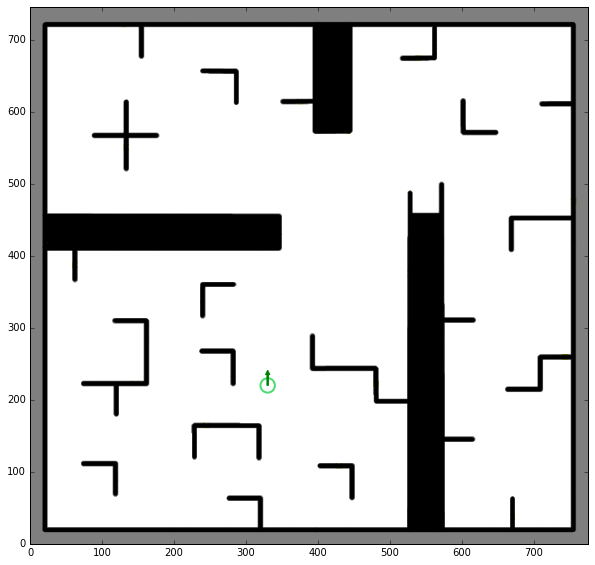

In [115]:
inspercles.nb_draw_map(color_image, pose=pose, robot=True)

A função *nb_initialize_particle_cloud()* pertence ao módulo <code>inspercles</code> e já faz uma primeira aleatorização das partículas

In [116]:
# Inicializa as particulas
particulas = inspercles.nb_initialize_particle_cloud()
print(particulas)

[<pf.Particle object at 0x7f0133614d50>, <pf.Particle object at 0x7f0133614b90>, <pf.Particle object at 0x7f0133614c10>, <pf.Particle object at 0x7f01336149d0>, <pf.Particle object at 0x7f0133614a10>, <pf.Particle object at 0x7f0133614550>, <pf.Particle object at 0x7f01336145d0>, <pf.Particle object at 0x7f0133614610>, <pf.Particle object at 0x7f0133614450>, <pf.Particle object at 0x7f01336144d0>, <pf.Particle object at 0x7f0133614290>, <pf.Particle object at 0x7f01336142d0>, <pf.Particle object at 0x7f0132ed3790>, <pf.Particle object at 0x7f0132ed37d0>, <pf.Particle object at 0x7f0132ed36d0>, <pf.Particle object at 0x7f0132ed3710>, <pf.Particle object at 0x7f0133609110>, <pf.Particle object at 0x7f0133609190>, <pf.Particle object at 0x7f01336091d0>, <pf.Particle object at 0x7f0133609090>, <pf.Particle object at 0x7f01330bd490>, <pf.Particle object at 0x7f0138fc0510>, <pf.Particle object at 0x7f01392cf2d0>, <pf.Particle object at 0x7f01330023d0>, <pf.Particle object at 0x7f0138b717d0>,

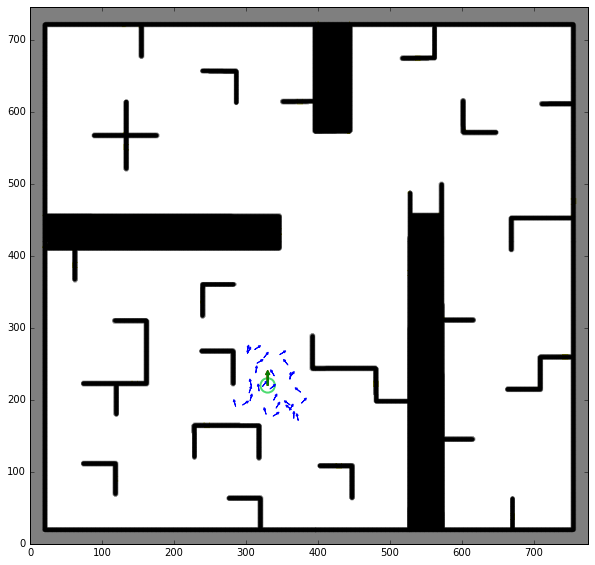

In [117]:
inspercles.nb_draw_map(color_image, particles = particulas, initial_position = initial_pose, pose=pose, robot=True)

In [118]:
angles

array([ 0.        ,  0.8975979 ,  1.7951958 ,  2.6927937 ,  3.5903916 ,
        4.48798951,  5.38558741,  6.28318531])

# Simulação da imagem do laser

Para simular a leitura **real** do robo, use *nb_simulate_lidar* passando a posição real do robô, os ângulos do sensor e a np_image com o mapa

In [119]:
leituras, lidar_map = inspercles.nb_simulate_lidar(pose, angles, np_image)


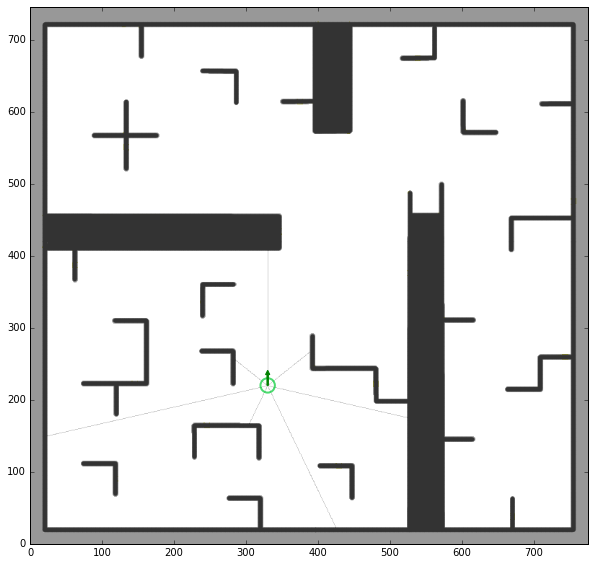

In [120]:
ax = inspercles.nb_draw_map(lidar_map, robot=True, pose=pose)
ax.imshow(color_image, alpha=0.8)
#nb_draw_map(occupancy_image)

As leituras serao retornadas pela simulacao do lidar. Sao armazenadas na forma de um dicionario com angulo: valor da leitura

In [121]:
# As predicoes teoricas das leituras
leituras

{0.0: 187.0,
 0.89759790102565518: 57.0087712549569,
 1.7951958020513104: 313.90444405901616,
 2.6927937030769655: 59.033888572581766,
 3.5903916041026207: 218.27734651126764,
 4.4879895051282759: 198.17668884104407,
 5.3855874061539311: 74.02702209328699,
 6.2831853071795862: 187.0}

In [122]:
leituras

{0.0: 187.0,
 0.89759790102565518: 57.0087712549569,
 1.7951958020513104: 313.90444405901616,
 2.6927937030769655: 59.033888572581766,
 3.5903916041026207: 218.27734651126764,
 4.4879895051282759: 198.17668884104407,
 5.3855874061539311: 74.02702209328699,
 6.2831853071795862: 187.0}

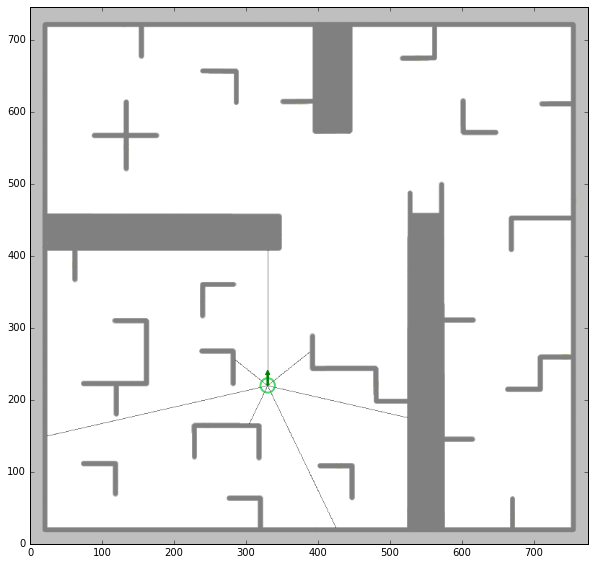

In [123]:
ax = inspercles.nb_draw_map(lidar_map, pose=pose, robot=True)
#ax.imshow(occupancy_image, alpha=0.2)
ax.imshow(pil_image, alpha=0.5)

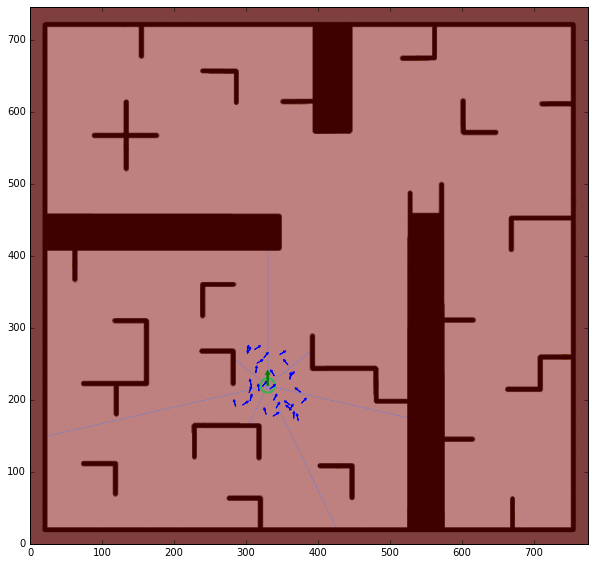

In [124]:
ax = inspercles.nb_draw_map(pil_image, pose=pose, robot=True, particles=particulas)
#ax.imshow(occupancy_image, alpha=0.2)
ax.imshow(lidar_map, alpha=0.5)

## Gerando uma animação

In [125]:
# Coloque nesta lista os deslocamentos do robo

dx = np.random.normal(loc = 0, scale = 2)
dy = np.random.normal(loc = -0.1, scale = 2)
dtheta = np.random.normal(loc = 0, scale = math.pi/100.0)

movimentos = [[-10, -10, 0], [-10, 10, 0], [-10,0,0], [-10, 0, 0],
              [0,0,math.pi/12.0], [0, 0, math.pi/12.0], [0, 0, math.pi/12],[0,0,-math.pi/4],
              [-5, 0, 0],[-5,0,0], [-5,0,0], [-10,0,0],[-10,0,0], [-10,0,0],[-10,0,0],[-10,0,0],[-15,0,0],
              [0,0,-math.pi/4],[0, 10, 0], [0,10,0], [0, 10, 0], [0,10,0], [0,0,math.pi/8], [0,10,0], [0,10,0], 
              [0,10,0], [0,10,0], [0,10,0],[0,10,0],
              [0,0,-math.radians(90)],
              [math.cos(math.pi/3)*10, math.sin(math.pi/3),0],[math.cos(math.pi/3)*10, math.sin(math.pi/3),0],[math.cos(math.pi/3)*10, math.sin(math.pi/3),0],
              [math.cos(math.pi/3)*10, math.sin(math.pi/3),0]
              ]


In [126]:

plt.ioff() # Desliga o modo interativo, para nao aparecerem muitas imagens no meio

W =[]

frames = 1


for delta in movimentos:
    for i in range(len(pose)):
        pose[i] += delta[i]
    
    # Simula a leitura do lidar
    leituras, lidar_map = inspercles.nb_simulate_lidar(pose, angles, np_image)


    produto_raios = []

    for p in particulas:
        dx = np.random.normal(loc = 0, scale = 2)
        dy = np.random.normal(loc = -0.1, scale = 2)
        dtheta = np.random.normal(loc = 0, scale = math.pi)
        p.x += (delta[0] + dx)
        p.y += (delta[1] + dy)
        p.theta += (delta[2] + dtheta)
        
    
   
        
        pose_part = [p.x, p.y, p.theta]
        # Simula a leitura do laser se o robo estivesse no lugar da particula p
        leituras_part, temp = inspercles.nb_simulate_lidar_fast(pose_part, angles, np_image, output_image=False)
        
        raio_atual = 1
        for i in leituras.keys():
            raio_atual *= math.e**(-(leituras[i] - leituras_part[i])/(2*2**2)) # sigma = 2
            
            
        produto_raios.append(raio_atual)
    
            
    
    alfa = 1/np.sum(produto_raios)    
    for i in range(len(produto_raios)):
            produto_raios[i] *= alfa
            

        
    

   
    #probabilidades = []
    #for i in range(len(particulas)):
        #for j in leituras:
            #probabilidades.append((reduce(operator.mul, (math.e, ((-(j-i))/16),1)))*(1/(7)))
    
    #print(probabilidades)
    
    

    # Desenha as particulas
    ax = inspercles.nb_draw_map(color_image, pose=pose, robot=True, particles =particulas)
    #ax.imshow(occupancy_image, alph.2)
    # Desenha o mapa do lidar
    ax.imshow(lidar_map, alpha=0.5)
    
    plt.savefig("anim%04d.png"%frames, bounds="tight")
    
    frames+=1
    plt.close('all')
    


print (produto_raios)
print (alfa)
print (sum(produto_raios))
plt.ion()



[1.0426732379729363e-52, 1.1319197195117424e-100, 4.4114066309913462e-79, 7.0238794419721858e-66, 8.34857398081004e-54, 5.7227712413757734e-54, 4.8993371047035715e-18, 1.2278524551540401e-52, 2.8710771109141037e-80, 7.3299408024374706e-57, 1.6528706850100417e-59, 5.8053391174154941e-31, 4.9820669276009886e-53, 4.381184399654193e-65, 2.3909265664338002e-48, 1.7183399610487272e-53, 4.4110006307812322e-59, 3.0099361305364564e-63, 1.2432174157017297e-52, 3.8957115449678163e-74, 2.5166663827433496e-59, 3.3271083510935481e-54, 4.2701503525980361e-05, 1.0776432277927279e-28, 1.0229864264492108e-73, 6.9023556204238481e-37, 0.99995729849647408, 1.604439346895387e-38, 6.0283689822085348e-65, 1.0343184367514323e-45]
1.56132721696e-76
1.0


In [127]:
leituras_part[6.2831853071795862]

97.10864901684964

Para gerar os gifs é preciso ter o pacote *imagemagick*

O imagemagick pode ser obtido com o seguinte comando:
    sudo apt-get install imagemagick 
    
Agora vamos invocar na linha de comando o seguinte comando:
    convert -delay 10 -loop 1 anim*png animated.gif
    
Este comando criou um arquivo chamado *animated.fig*, que leremos abaixo:
    

In [128]:
!convert -delay 10 -loop 1 anim*png animated.gif

Infelizmente o IPython Notebook 2 nao parece exibir animacoes em Gif por default, mas voce pode abrir o arquivo no diretorio de trabalho e devera'  ve-lo.

<img src="animated.gif">

In [129]:
print (W)

[]


In [130]:
print (leituras)

{0.0: 6.9282032302754715, 6.2831853071795862: 6.9282032302754715, 5.3855874061539311: 54.299925950994556, 3.5903916041026207: 206.37672792510418, 0.89759790102565518: 6.5138913575793795, 2.6927937030769655: 112.26418092591263, 1.7951958020513104: 35.05322064018563, 4.4879895051282759: 111.39458551040062}


In [131]:
novas_particulas = Particle.draw_random_sample(particulas, particulas_pesos, 10)

NameError: name 'particulas_pesos' is not defined

In [ ]:


for p in novas_particulas:
    p.w = 1



![](anim.gif)